<a href="https://colab.research.google.com/github/sircfilip/VU/blob/main/VAE_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.03MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/10], Loss: 193.6933
Epoch [2/10], Loss: 161.4867
Epoch [3/10], Loss: 156.6254
Epoch [4/10], Loss: 153.9379
Epoch [5/10], Loss: 152.0551
Epoch [6/10], Loss: 150.6018
Epoch [7/10], Loss: 149.4660
Epoch [8/10], Loss: 148.5857
Epoch [9/10], Loss: 147.8125
Epoch [10/10], Loss: 147.2160


Epoch,▁▂▃▃▄▅▆▆▇█
Loss,█▃▂▂▂▂▁▁▁▁
Epoch,10
Loss,147.21596


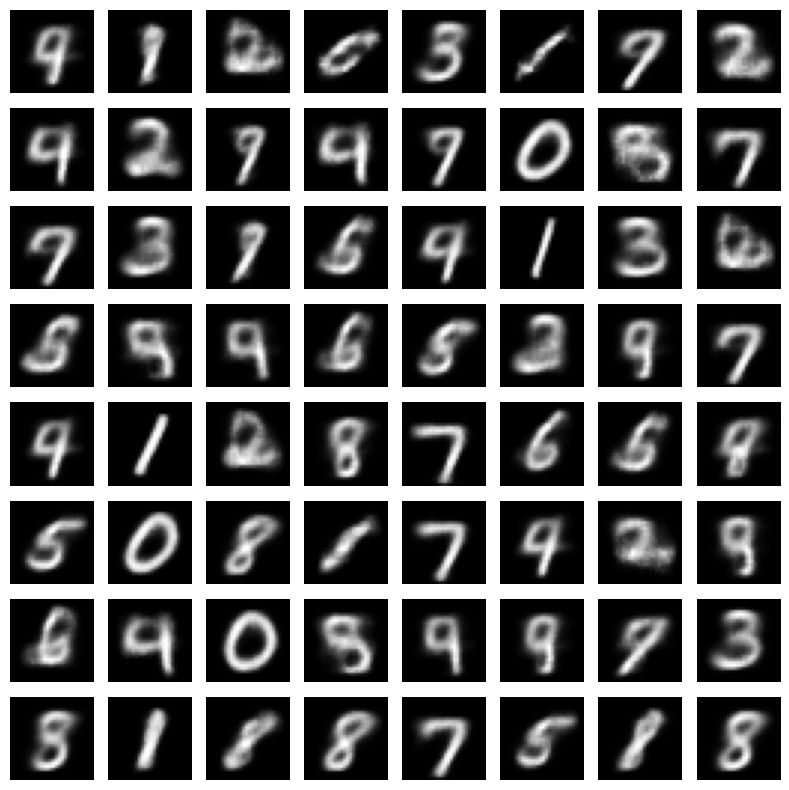

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import wandb

# Initialize wandb
wandb.init(project="vae-mnist", config={
    "batch_size": 128,
    "latent_dim": 2,
    "learning_rate": 1e-3,
    "num_epochs": 10
})

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters from wandb config
config = wandb.config
batch_size = config.batch_size
latent_dim = config.latent_dim
learning_rate = config.learning_rate
num_epochs = config.num_epochs

# MNIST dataset loading with normalization to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var

# Loss function
def vae_loss(x, x_reconstructed, mu, log_var):
    recon_loss = nn.functional.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_div

# Initialize model and optimizer
vae = VAE(latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()
        x_reconstructed, mu, log_var = vae(data)
        loss = vae_loss(data, x_reconstructed, mu, log_var)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Log the training loss to wandb
    wandb.log({"Epoch": epoch+1, "Loss": avg_loss})

# Save model to wandb
torch.save(vae.state_dict(), "vae_model.pth")
wandb.save("vae_model.pth")

# Testing (generating new images)
vae.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    generated_images = vae.decoder(z).cpu()

# Log generated images to wandb
generated_images = generated_images.view(generated_images.size(0), 1, 28, 28)
fig, axs = plt.subplots(8, 8, figsize=(8, 8))
axs = axs.flatten()

for img, ax in zip(generated_images, axs):
    ax.imshow(img.squeeze(), cmap='gray')
    ax.axis('off')

# Save the plot to wandb
plt.tight_layout()
wandb.log({"Generated Images": wandb.Image(plt)})

# Close the wandb run
wandb.finish()


Generating pictures using pre learned code

In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import wandb

# Initialize wandb
run = wandb.init(project="VAE-MNIST", entity="fsirc-czech-technical-university-in-prague", job_type="inference")

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        raise NotImplementedError("Only decoder is needed for generating images.")

# Load the model weights from the specified run and file path in wandb
artifact = run.use_artifact('fsirc-czech-technical-university-in-prague/VAE-MNIST/v8pfc2nu', type='model')
artifact_dir = artifact.download()

# Restore the model architecture
latent_dim = 2  # Adjust according to your model configuration
vae = VAE(latent_dim)
vae.load_state_dict(torch.load(f"{artifact_dir}/vae_model.pth"))  # Assuming the file is named vae_model.pth
vae.eval()  # Set the model to evaluation mode

# Generate new images from random latent space
with torch.no_grad():
    z = torch.randn(64, latent_dim)  # Random latent vector
    generated_images = vae.decoder(z).cpu()

# Plot generated images
generated_images = generated_images.view(generated_images.size(0), 1, 28, 28)
fig, axs = plt.subplots(8, 8, figsize=(8, 8))
axs = axs.flatten()

for img, ax in zip(generated_images, axs):
    ax.imshow(img.squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()

# Log generated images to wandb
wandb.log({"Generated Images": wandb.Image(plt)})

# Save locally if desired
plt.savefig("generated_images.png")

# Finish the wandb run
wandb.finish()

CommError: artifacts must be specified as 'collection:alias' (Error 400: Bad Request)